# Overview of NER, LSTM, and CoNLL-2003 Dataset

## Named Entity Recognition (NER)

Named Entity Recognition (NER) is a subtask of natural language processing (NLP) focused on identifying and categorizing key information (entities) in text into predefined categories. Common categories include person names, organizations, locations, date expressions, quantities, monetary values, and percentages. NER is crucial for various applications such as information retrieval, question answering systems, content classification, and knowledge graph construction.

## Long Short-Term Memory Networks (LSTMs)

Long Short-Term Memory networks (LSTMs) are a special kind of Recurrent Neural Network (RNN) capable of learning long-term dependencies. LSTMs are designed to avoid the long-term dependency problem by using a series of gates that control the flow of information. These include:

- **Input gate**: Determines how much of the new input to let into the cell state.
- **Forget gate**: Decides what information is discarded from the cell state.
- **Output gate**: Determines what information to output based on the current input and the memory of the cell.

LSTMs are particularly useful in tasks where context and sequence in data are essential, making them ideal for applications like time series prediction, sequence prediction, and natural language processing tasks, including NER.

## CoNLL-2003 Dataset

The CoNLL-2003 dataset is a benchmark dataset widely used for training and evaluating NER systems. It originated from the CoNLL-2003 shared task and includes text from Reuters news stories, annotated for named entity recognition. The dataset is notable for its four types of named entities: persons (PER), organizations (ORG), locations (LOC), and miscellaneous (MISC).

### Dataset Details

- **Source**: Reuters news stories.
- **Languages**: Primarily English, with some datasets also in German.
- **Annotation Types**: PER, LOC, ORG, MISC.
- **Applications**: Used extensively in NLP to benchmark NER systems.

### Tagging Scheme

The tagging scheme used in the CoNLL-2003 dataset employs the BIO format (Beginning, Inside, Outside), which helps in distinguishing the boundaries of entities:

- `O`: `0` - "O" stands for "Outside" any named entity. Most tokens are labeled with "O".
- `B-PER`: `1` - "Beginning of a Person's name". Marks the start of a person's name.
- `I-PER`: `2` - "Inside a Person’s name". Used for tokens inside a person's name but not the first.
- `B-ORG`: `3` - "Beginning of an Organization’s name". Marks the start of an organization's name.
- `I-ORG`: `4` - "Inside an Organization’s name". For tokens within an organization's name but not the first.
- `B-LOC`: `5` - "Beginning of a Location". Used for the start of a geographic location or place name.
- `I-LOC`: `6` - "Inside a Location". For tokens that are part of a location's name but not the first.
- `B-MISC`: `7` - "Beginning of a Miscellaneous entity". Used for the start of entities not classified as PER, ORG, or LOC.
- `I-MISC`: `8` - "Inside a Miscellaneous entity". For tokens inside a miscellaneous entity but not the first.

## Importing necessary libraries and the CoNLL dataset

In [1]:
pip install tensorflow transformers datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.9 MB/s eta 0:00:00a 0:00:01
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=0ed3244fcfd1ed65608650743b9cae9d646ef520da9bc66594bb4528d0658537
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset

# Loading the conll2003 dataset from datasets
dataset = load_dataset("conll2003")

# Displaying the First sentence tokens and associated NER tags 
first_sentence = dataset['train'][0]
print("Sentence:", first_sentence['tokens'])
print("NER Labels:", first_sentence['ner_tags'])

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Sentence: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
NER Labels: [3, 0, 7, 0, 0, 0, 7, 0, 0]


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2024-05-10 17:02:33.572755: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 17:02:33.572884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 17:02:33.692620: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Function to convert the dataset format to a DataFrame
def dataset_to_dataframe(dataset):
    df_list = []
    for sentence in dataset:
        for word, pos, chunk, ner in zip(sentence['tokens'], sentence['pos_tags'], sentence['chunk_tags'], sentence['ner_tags']):
            df_list.append({'Word': word, 'POS': pos, 'Chunk': chunk, 'Tag': ner})
    return pd.DataFrame(df_list)



In [5]:
# Convert training data to DataFrame
train_df = dataset_to_dataframe(dataset['train'])

# Map numeric tags to actual entity names
tag_dict = {
    0: 'Outside',
    1: 'Beginning-PER',
    2: 'Inside-PER',
    3: 'Beginning-ORG',
    4: 'Inside-ORG',
    5: 'Beginning-LOC',
    6: 'Inside-LOC',
    7: 'Beginning-MISC',
    8: 'Inside-MISC'
}


train_df['Tag'] = train_df['Tag'].map(lambda x: tag_dict[x])

In [6]:
# Analyze the distribution of entity tags
tag_counts = train_df['Tag'].value_counts()

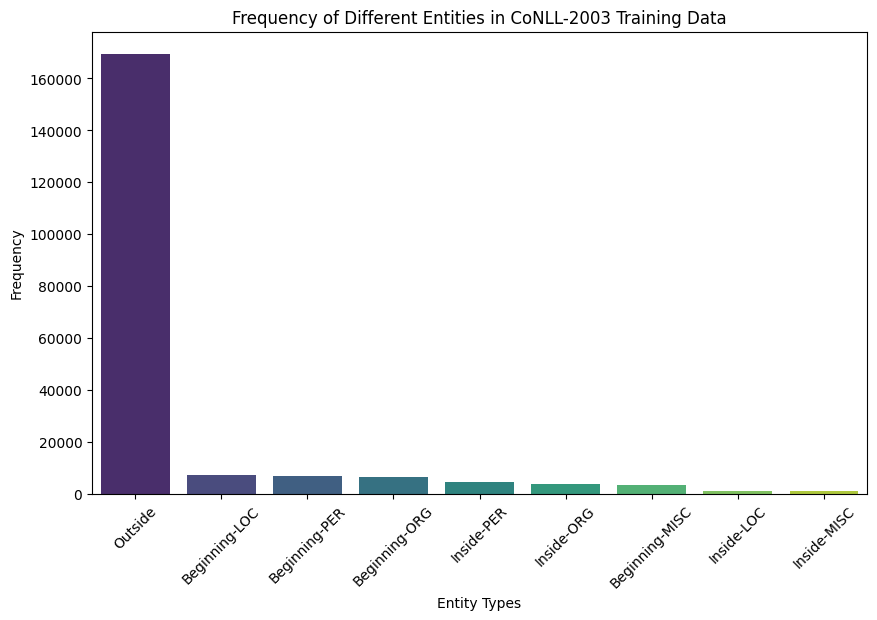

In [7]:
# Plotting the frequency of different entities
plt.figure(figsize=(10, 6))
sns.barplot(x=tag_counts.index, y=tag_counts.values, palette='viridis')
plt.title('Frequency of Different Entities in CoNLL-2003 Training Data')
plt.ylabel('Frequency')
plt.xlabel('Entity Types')
plt.xticks(rotation=45)
plt.show()



In [8]:
# Additional statistics
num_sentences = len(dataset['train'])
num_tokens = len(train_df)
unique_tokens = train_df['Word'].nunique()

print(f"Number of sentences: {num_sentences}")
print(f"Number of tokens: {num_tokens}")
print(f"Number of unique tokens: {unique_tokens}")

Number of sentences: 14041
Number of tokens: 203621
Number of unique tokens: 23623


## Feature Engineering

In [9]:
# Function to convert dataset into a more usable format

def sentences_and_labels(dataset):
    sentences, labels = [], []
    for data in dataset['train']:
        sentences.append(data['tokens'])
        labels.append(data['ner_tags'])

    return sentences, labels

sentences, labels = sentences_and_labels(dataset)

In [10]:
# Tokenization
tok = tf.keras.preprocessing.text.Tokenizer(oov_token = 'UNK')
tok.fit_on_texts(sentences)
X_enc = tok.texts_to_sequences(sentences)

In [11]:
# Padding
max_len = max(map(len, sentences))
X_pad = pad_sequences(X_enc, maxlen = max_len, padding ='post')

In [12]:
# prepare labels

tag2idx = {tag: idx for idx, tag in enumerate(set([tag for sublist in labels for tag in sublist]))}
y_enc = [[tag2idx[tag] for tag in doc] for doc in labels]
y_pad = pad_sequences(y_enc, maxlen = max_len, padding = 'post', value = tag2idx[0])
y_cat = [to_categorical(i, num_classes=len(tag2idx)) for i in y_pad]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, np.array(y_cat), test_size = 0.1, random_state = 42)

## Model Building

In [14]:
model = Sequential([
    Embedding(input_dim = len(tok.word_index)+1, output_dim = 64, input_length = max_len),
    SpatialDropout1D(0.1),
    LSTM(units=100, return_sequences = True),
    TimeDistributed(Dense(len(tag2idx), activation = 'softmax'))
])

In [15]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Model Evaluation and Results visualisation

Epoch 1/5
395/395 [==============================] - 36s 86ms/step - loss: 0.1696 - accuracy: 0.9746 - val_loss: 0.0702 - val_accuracy: 0.9795
Epoch 2/5
395/395 [==============================] - 34s 85ms/step - loss: 0.0556 - accuracy: 0.9824 - val_loss: 0.0487 - val_accuracy: 0.9849
Epoch 3/5
395/395 [==============================] - 34s 85ms/step - loss: 0.0393 - accuracy: 0.9874 - val_loss: 0.0404 - val_accuracy: 0.9878
Epoch 4/5
395/395 [==============================] - 34s 85ms/step - loss: 0.0285 - accuracy: 0.9917 - val_loss: 0.0327 - val_accuracy: 0.9910
Epoch 5/5
395/395 [==============================] - 34s 86ms/step - loss: 0.0191 - accuracy: 0.9953 - val_loss: 0.0267 - val_accuracy: 0.9929


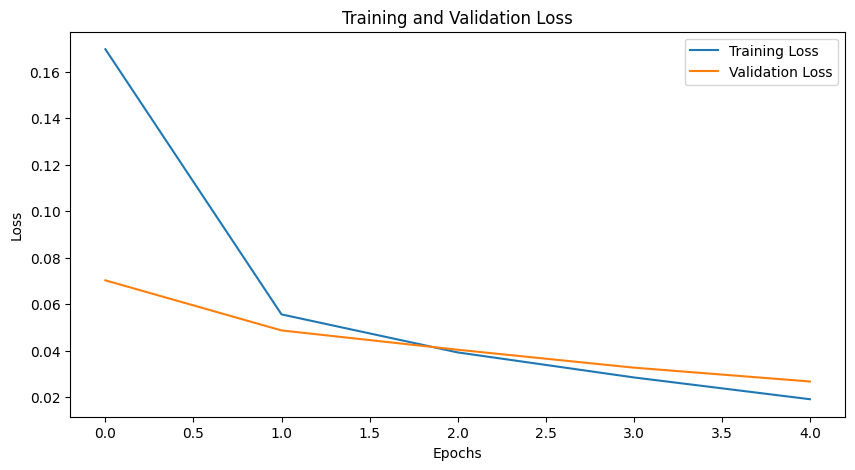

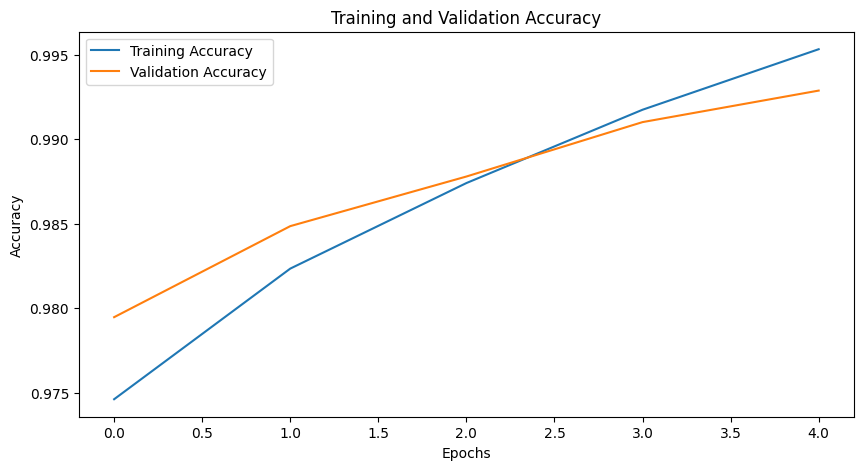

In [16]:
import matplotlib.pyplot as plt

# Fit the model and save the training history
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy if available
if 'accuracy' in history.history:
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Model Evaluation

In [17]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

44/44 [==============================] - 1s 22ms/step - loss: 0.0267 - accuracy: 0.9929
Test loss: 0.026744071394205093, Test accuracy: 0.9928825497627258


## Making Predictions using the Model

In [18]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model

# Assuming 'model' and 'tok' are already loaded and configured
# Assuming 'max_len' and 'tag2idx' are known from your model's training data
# Reverse tag dictionary to map indices to tags
idx2tag = {i: w for w, i in tag2idx.items()}

def preprocess_sentence(sentences, tokenizer, max_len):
    # Tokenize and pad sentences as done with the training data
    seq = tokenizer.texts_to_sequences(sentences)
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')
    seq_lengths = [len(s) for s in seq]  # Keep track of the original lengths before padding
    return padded_seq, seq_lengths

def decode_predictions(pred, seq_lengths, idx2tag):
    out = []
    for idx, pred_i in enumerate(pred):
        out_i = []
        length = seq_lengths[idx]  # Length of the actual sentence
        for j in range(length):  # Only iterate over the actual sentence length
            p = pred_i[j]
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

# Prepare new sentences for testing
new_sentences = [
    "Facebook and Google are big tech companies.",
    "Barack Obama was the president of the United States.",
    "I love to visit Paris and New York."
]

# Preprocess these new sentences and obtain original lengths
new_X, new_lengths = preprocess_sentence(new_sentences, tok, max_len)

# Predict using the model
predictions = model.predict(new_X)

# Decode predictions to get tag names instead of indices
decoded_predictions = decode_predictions(predictions, new_lengths, idx2tag)

# Print the results
for i, (sent, pred) in enumerate(zip(new_sentences, decoded_predictions)):
    print(f"Sentence {i+1}: {sent}")
    print(f"Predicted tags: {pred}")
    print()

1/1 [==============================] - 0s 436ms/step
Sentence 1: Facebook and Google are big tech companies.
Predicted tags: [0, 0, 3, 0, 0, 0, 0]

Sentence 2: Barack Obama was the president of the United States.
Predicted tags: [0, 0, 0, 0, 0, 0, 0, 5, 6]

Sentence 3: I love to visit Paris and New York.
Predicted tags: [0, 1, 0, 0, 5, 0, 4, 6]

